In [1]:
! pip install datasets

  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/d7/84/0df6c5981f5fc722381662ff8cfbdf8aad64bec875f75d80b55bfef394ce/datasets-3.2.0-py3-none-any.whl.metadata
  Using cached datasets-3.2.0-py3-none-any.whl.metadata (20 kB)
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/89/ec/00d68c4ddfedfe64159999e5f8a98fb8442729a63e2077eb9dcd89623d27/filelock-3.17.0-py3-none-any.whl.metadata
  Obtaining dependency information for dill<0.3.9,>=0.3.0 from https://files.pythonhosted.org/packages/c9/7a/cef76fd8438a42f96db64ddaa85280485a9c395e7df3db8158cfec1eee34/dill-0.3.8-py3-none-any.whl.metadata
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Obtaining dependency information for requests>=2.32.2 from https://files.pythonhosted.org/packages/f9/9b/335f9764261e915ed497fcdeb11df5dfd6f7bf257d4a6a2a686d80da4d54/requests-2.32.3-py3-none-any.whl.metadata
  Using cached requests-2.32.3-py3-none-any.whl.metadata


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import json
import os
from tqdm import tqdm

# Путь к вашему файлу в COCO-формате
COCO_JSON = r"table_dataset/images/train/_annotations.coco.json"
# Папка, где лежат сами изображения
IMAGES_DIR = r"table_dataset/images/train"  
# Папка, куда мы хотим сложить новые txt-файлы
OUTPUT_LABELS_DIR = r"table_dataset/labels/train"

# Убедитесь, что папка для labels существует
os.makedirs(OUTPUT_LABELS_DIR, exist_ok=True)

with open(COCO_JSON, 'r', encoding='utf-8') as f:
    coco_data = json.load(f)

images_info = {img['id']: img for img in coco_data['images']}
categories_info = {cat['id']: cat['name'] for cat in coco_data['categories']}

# Группируем аннотации по ID картинки
annotations_by_image = {}
for ann in coco_data['annotations']:
    img_id = ann['image_id']
    if img_id not in annotations_by_image:
        annotations_by_image[img_id] = []
    annotations_by_image[img_id].append(ann)

for img_id, image_dict in tqdm(images_info.items()):
    file_name = image_dict['file_name']
    width = image_dict['width']
    height = image_dict['height']
    
    # Имя txt-файла такое же, как у изображения, только с .txt
    txt_file_name = os.path.splitext(file_name)[0] + ".txt"
    txt_path = os.path.join(OUTPUT_LABELS_DIR, txt_file_name)
    
    # Составляем контент для этого txt
    yolo_lines = []
    if img_id in annotations_by_image:
        for ann in annotations_by_image[img_id]:
            cat_id = ann['category_id']  # ID класса из COCO
            # COCO bbox: [x_min, y_min, width, height] (в пикселях)
            x, y, w, h = ann['bbox']
            
            # Координаты центра и ширины/высоты в YOLO-формате (нормализованные)
            x_center = x + w/2
            y_center = y + h/2
            x_center_norm = x_center / width
            y_center_norm = y_center / height
            w_norm = w / width
            h_norm = h / height

            # Формируем строчку: <class_id> <x_center> <y_center> <width> <height>
            # Все значения - float, YOLO читает в том числе с плавающей точкой
            yolo_line = f"{cat_id} {x_center_norm:.6f} {y_center_norm:.6f} {w_norm:.6f} {h_norm:.6f}"
            yolo_lines.append(yolo_line)
    
    # Записываем содержимое в txt файл
    with open(txt_path, "w", encoding="utf-8") as f_txt:
        for line in yolo_lines:
            f_txt.write(line + "\n")


100%|██████████| 238/238 [00:00<00:00, 7694.78it/s]


In [8]:
! pip install ultralytics

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/22/4a/5b2a7577c7b770aa5c232576fa4116f6c0527b745d2a04bf5a19bcfc80ca/ultralytics-8.3.72-py3-none-any.whl.metadata
  Obtaining dependency information for opencv-python>=4.6.0 from https://files.pythonhosted.org/packages/a4/7d/f1c30a92854540bf789e9cd5dde7ef49bbe63f855b85a2e6b3db8135c591/opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata
  Obtaining dependency information for scipy>=1.4.1 from https://files.pythonhosted.org/packages/af/25/caa430865749d504271757cafd24066d596217e83326155993980bc22f97/scipy-1.15.1-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     -------------------------------- ----- 51.2/60.8 kB 871.5 kB/s eta 0:00:01
     ---------------------------------------- 60.8/60.8 kB 1.1 MB/s eta 0:00:00
  Obtaining dependency information for torch>=1.8.0 from https://files.pythonhosted.org/packages/11/c5/2370d96b31eb1841


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from ultralytics import YOLO

# Загружаем предобученные веса (например, yolo8s.pt)
model = YOLO('yolov8s.pt')

# Запускаем обучение
model.train(
    data='table_data.yaml',  # data.yaml
    epochs=50,               # кол-во эпох 
    imgsz=640,               # размер входного изображения 
    batch=16,                # размер batch
    name='table_detection'   # подпапка для логов (runs/detect/table_detection/)
)

Ultralytics 8.3.72  Python-3.11.7 torch-2.6.0+cpu CPU (12th Gen Intel Core(TM) i7-12700K)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=table_data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=table_detection4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

train: Scanning F:\GitHub\datasets\table_dataset\labels\train... 238 images, 0 backgrounds, 0 corrupt: 100%|██████████| 238/238 [00:00<00:00, 676.06it/s]

train: New cache created: F:\GitHub\datasets\table_dataset\labels\train.cache



val: Scanning F:\GitHub\datasets\table_dataset\labels\val... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 750.92it/s]

val: New cache created: F:\GitHub\datasets\table_dataset\labels\val.cache


Plotting labels to f:\GitHub\table-parser\runs\detect\table_detection4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to f:\GitHub\table-parser\runs\detect\table_detection4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.269      2.827      1.354         51        640: 100%|██████████| 15/15 [01:26<00:00,  5.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.63s/it]

                   all         70        109      0.337      0.453      0.343       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G     0.6833      1.541      1.027         50        640: 100%|██████████| 15/15 [01:23<00:00,  5.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.99s/it]

                   all         70        109      0.364      0.752      0.656      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G     0.6272      1.239     0.9826         54        640: 100%|██████████| 15/15 [01:23<00:00,  5.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.95s/it]

                   all         70        109      0.467      0.505       0.52      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G        0.7      1.093      1.012         49        640: 100%|██████████| 15/15 [01:24<00:00,  5.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.96s/it]

                   all         70        109       0.34      0.474      0.362      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G     0.7368      1.095      1.041         48        640: 100%|██████████| 15/15 [01:24<00:00,  5.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  3.00s/it]

                   all         70        109      0.337      0.595       0.26      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G     0.7534       1.12      1.046         45        640: 100%|██████████| 15/15 [01:23<00:00,  5.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.06s/it]

                   all         70        109      0.469      0.199      0.274      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      0.763      1.112      1.044         44        640: 100%|██████████| 15/15 [01:24<00:00,  5.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.22s/it]

                   all         70        109      0.256      0.623      0.419      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G     0.7407      1.028      1.031         54        640: 100%|██████████| 15/15 [01:27<00:00,  5.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.96s/it]

                   all         70        109      0.564      0.788      0.723      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G     0.7251     0.8838      1.022         64        640: 100%|██████████| 15/15 [01:27<00:00,  5.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.42s/it]

                   all         70        109      0.574      0.665      0.664      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G        0.7     0.8716     0.9879         53        640: 100%|██████████| 15/15 [01:32<00:00,  6.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.25s/it]

                   all         70        109      0.714      0.698      0.803      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G     0.6805      0.853     0.9915         47        640: 100%|██████████| 15/15 [01:31<00:00,  6.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.27s/it]

                   all         70        109      0.759       0.72      0.783      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G     0.6837     0.8888     0.9851         57        640: 100%|██████████| 15/15 [01:33<00:00,  6.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.28s/it]

                   all         70        109      0.411      0.611      0.561      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G     0.6758     0.9104      1.008         50        640: 100%|██████████| 15/15 [01:32<00:00,  6.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.30s/it]

                   all         70        109      0.459      0.683      0.634      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G     0.6405     0.8827     0.9677         52        640: 100%|██████████| 15/15 [01:23<00:00,  5.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.94s/it]

                   all         70        109      0.903      0.868      0.934      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G     0.6177     0.7944     0.9667         50        640: 100%|██████████| 15/15 [01:23<00:00,  5.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.96s/it]

                   all         70        109      0.879      0.792      0.903      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G     0.5804     0.7393     0.9477         55        640: 100%|██████████| 15/15 [01:23<00:00,  5.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.94s/it]

                   all         70        109      0.802      0.829      0.875      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G     0.5964     0.7989     0.9652         58        640: 100%|██████████| 15/15 [01:27<00:00,  5.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.29s/it]

                   all         70        109      0.856      0.814      0.881      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.5641     0.6877     0.9474         56        640: 100%|██████████| 15/15 [01:28<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.97s/it]

                   all         70        109      0.834       0.84      0.897      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.5438     0.6865     0.9445         46        640: 100%|██████████| 15/15 [01:28<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.44s/it]

                   all         70        109       0.65      0.674      0.679      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G     0.5172     0.6425     0.9324         59        640: 100%|██████████| 15/15 [01:35<00:00,  6.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.32s/it]

                   all         70        109      0.832      0.814      0.879      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.5345     0.6687     0.9499         50        640: 100%|██████████| 15/15 [01:37<00:00,  6.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.37s/it]

                   all         70        109      0.821       0.71      0.771      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G     0.5211     0.6909      0.946         57        640: 100%|██████████| 15/15 [01:33<00:00,  6.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.48s/it]

                   all         70        109      0.897      0.792      0.865      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.5083       0.62     0.9316         51        640: 100%|██████████| 15/15 [01:30<00:00,  6.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.15s/it]

                   all         70        109      0.876      0.823      0.881      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.4743      0.585     0.9296         31        640: 100%|██████████| 15/15 [01:26<00:00,  5.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.03s/it]

                   all         70        109      0.896      0.875      0.917      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.4906     0.6484     0.9197         55        640: 100%|██████████| 15/15 [01:25<00:00,  5.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.04s/it]

                   all         70        109      0.878      0.852      0.892       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G     0.4779     0.6187     0.9339         51        640: 100%|██████████| 15/15 [01:28<00:00,  5.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.09s/it]

                   all         70        109      0.913      0.845      0.928      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.4387     0.5437     0.8963         39        640: 100%|██████████| 15/15 [01:28<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.13s/it]

                   all         70        109      0.863      0.877       0.93      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.4646     0.5538     0.9128         55        640: 100%|██████████| 15/15 [01:30<00:00,  6.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.11s/it]

                   all         70        109      0.928      0.822      0.929      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.4515     0.5448     0.9051         39        640: 100%|██████████| 15/15 [01:30<00:00,  6.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.18s/it]

                   all         70        109      0.889      0.826      0.914      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.4291     0.5231     0.9171         40        640: 100%|██████████| 15/15 [01:28<00:00,  5.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.19s/it]

                   all         70        109      0.882       0.86      0.894      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.4113     0.5041     0.8942         53        640: 100%|██████████| 15/15 [01:27<00:00,  5.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.16s/it]

                   all         70        109      0.921      0.817      0.887      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.4086     0.4961     0.9001         49        640: 100%|██████████| 15/15 [01:28<00:00,  5.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.15s/it]

                   all         70        109      0.953      0.771      0.909      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      0.409     0.4618     0.8985         50        640: 100%|██████████| 15/15 [01:28<00:00,  5.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.17s/it]

                   all         70        109       0.91      0.831      0.919      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.3811     0.4694     0.8773         48        640: 100%|██████████| 15/15 [01:27<00:00,  5.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.18s/it]

                   all         70        109        0.9      0.769      0.902        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.3882     0.4152     0.8853         50        640: 100%|██████████| 15/15 [01:27<00:00,  5.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.17s/it]

                   all         70        109      0.908       0.77       0.87      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.3594     0.4135     0.8807         53        640: 100%|██████████| 15/15 [01:28<00:00,  5.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.11s/it]

                   all         70        109      0.912      0.817      0.913      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.3689     0.4308     0.9076         58        640: 100%|██████████| 15/15 [01:27<00:00,  5.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.10s/it]

                   all         70        109      0.867      0.874      0.927      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.3583     0.4075     0.8695         56        640: 100%|██████████| 15/15 [01:28<00:00,  5.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.10s/it]

                   all         70        109      0.882      0.876      0.925      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.3558     0.4157     0.8866         48        640: 100%|██████████| 15/15 [01:28<00:00,  5.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.09s/it]

                   all         70        109      0.902      0.839      0.909      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.3564     0.4284     0.8747         54        640: 100%|██████████| 15/15 [01:28<00:00,  5.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.07s/it]

                   all         70        109      0.866      0.837      0.891      0.838


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.3343     0.3864     0.8453         20        640: 100%|██████████| 15/15 [01:27<00:00,  5.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.07s/it]

                   all         70        109      0.903      0.866      0.929      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.3177     0.3474     0.8519         22        640: 100%|██████████| 15/15 [01:27<00:00,  5.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.21s/it]

                   all         70        109      0.841      0.924      0.917      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.2916     0.3162     0.8159         19        640: 100%|██████████| 15/15 [01:27<00:00,  5.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.19s/it]

                   all         70        109      0.895      0.864      0.917      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.3178     0.3346     0.8403         23        640: 100%|██████████| 15/15 [01:27<00:00,  5.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.13s/it]

                   all         70        109      0.937      0.804      0.919      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.3155     0.3325     0.8503         22        640: 100%|██████████| 15/15 [01:27<00:00,  5.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.19s/it]

                   all         70        109      0.858       0.83      0.887        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.3086     0.3231     0.8381         20        640: 100%|██████████| 15/15 [01:27<00:00,  5.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.11s/it]

                   all         70        109      0.844      0.849      0.911      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.2721     0.2819     0.8164         20        640: 100%|██████████| 15/15 [01:27<00:00,  5.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.11s/it]

                   all         70        109      0.905      0.844      0.929      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.2663     0.2763     0.8275         19        640: 100%|██████████| 15/15 [01:28<00:00,  5.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.08s/it]

                   all         70        109      0.933      0.814      0.933      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.2698       0.27     0.8335         20        640: 100%|██████████| 15/15 [01:27<00:00,  5.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.08s/it]

                   all         70        109      0.862      0.867       0.93       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.2642     0.2602     0.8132         17        640: 100%|██████████| 15/15 [01:33<00:00,  6.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.34s/it]

                   all         70        109      0.889       0.81      0.929       0.86



50 epochs completed in 1.362 hours.
Optimizer stripped from f:\GitHub\table-parser\runs\detect\table_detection4\weights\last.pt, 22.5MB
Optimizer stripped from f:\GitHub\table-parser\runs\detect\table_detection4\weights\best.pt, 22.5MB

Validating f:\GitHub\table-parser\runs\detect\table_detection4\weights\best.pt...
Ultralytics 8.3.72  Python-3.11.7 torch-2.6.0+cpu CPU (12th Gen Intel Core(TM) i7-12700K)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.77s/it]


                   all         70        109      0.933      0.814      0.933      0.873
              bordered         18         23          1      0.779      0.957      0.926
            borderless         52         86      0.866      0.849      0.908       0.82
Speed: 1.5ms preprocess, 112.6ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to f:\GitHub\table-parser\runs\detect\table_detection4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001B63750F510>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

In [1]:
from ultralytics import YOLO

# Загрузим модель с нашими обученными весами
model = YOLO("../runs/detect/table_detection4/weights/best.pt")

# Запустим инференс на одном изображении
results = model.predict(
    source="table_dataset/images/test/cTDaR_t10040_jpg.rf.7d4b718b894e93ef76e1def5843009a8.jpg", 
    conf=0.25,  # порог confidence
    save=True
)

# Результаты автоматически сохранятся в "runs/detect/predict/"
# Также 'results' содержит детекции: боксы, классы и т.д.



image 1/1 f:\GitHub\table-parser\yolo\table_dataset\images\test\cTDaR_t10040_jpg.rf.7d4b718b894e93ef76e1def5843009a8.jpg: 640x640 1 bordered, 1 borderless, 139.7ms
Speed: 4.6ms preprocess, 139.7ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to f:\GitHub\table-parser\runs\detect\predict3


In [7]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'bordered', 1: 'borderless'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,

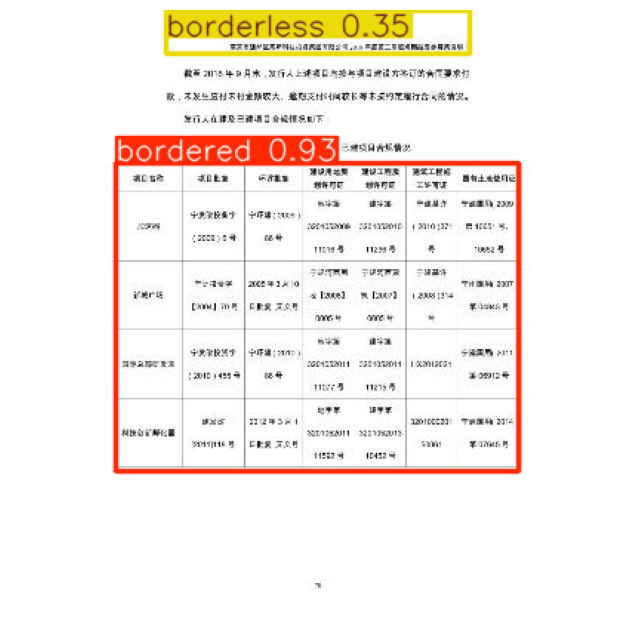

In [2]:
import matplotlib.pyplot as plt

for r in results:
    # r.plot() автоматически рисует все боксы и возвращает RGB-массив
    im_rgb = r.plot()
    
    plt.figure(figsize=(10, 8))
    plt.imshow(im_rgb)
    plt.axis('off')
    plt.show()

In [3]:
# Запустим инференс на одном изображении
results = model.predict(
    source="../resources/images/5.jpg", 
    conf=0.25,  # порог confidence
    save=True
)


image 1/1 f:\GitHub\table-parser\yolo\..\resources\images\5.jpg: 320x640 1 borderless, 59.7ms
Speed: 1.0ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)
Results saved to f:\GitHub\table-parser\runs\detect\predict3


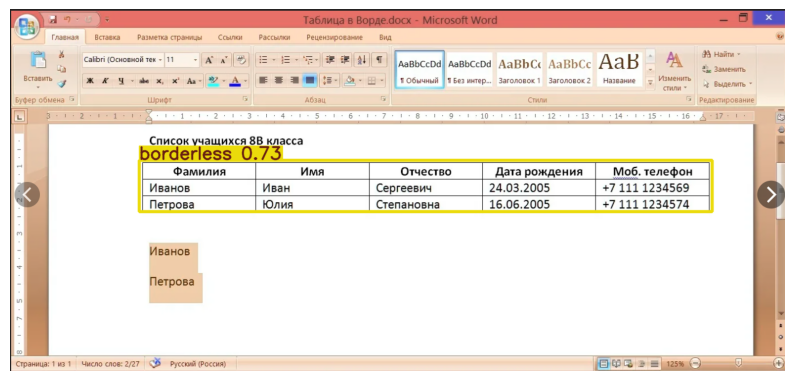

In [4]:
for r in results:
    # r.plot() автоматически рисует все боксы и возвращает RGB-массив
    im_rgb = r.plot()
    
    plt.figure(figsize=(10, 8))
    plt.imshow(im_rgb)
    plt.axis('off')
    plt.show()

# Аугментация

In [1]:
! pip install albumentations

  Obtaining dependency information for albumentations from https://files.pythonhosted.org/packages/97/d3/cf3aab593209d1be5e4bca54aeea297225708bd25f06426d6b8ec3630a76/albumentations-2.0.5-py3-none-any.whl.metadata
  Using cached albumentations-2.0.5-py3-none-any.whl.metadata (41 kB)
  Obtaining dependency information for pydantic>=2.9.2 from https://files.pythonhosted.org/packages/f4/3c/8cc1cc84deffa6e25d2d0c688ebb80635dfdbf1dbea3e30c541c8cf4d860/pydantic-2.10.6-py3-none-any.whl.metadata
  Using cached pydantic-2.10.6-py3-none-any.whl.metadata (30 kB)
  Obtaining dependency information for albucore==0.0.23 from https://files.pythonhosted.org/packages/3d/de/4d9298befa6ae0f21230378f55100dca364816e3734028ca2766f2eca263/albucore-0.0.23-py3-none-any.whl.metadata
  Using cached albucore-0.0.23-py3-none-any.whl.metadata (5.3 kB)
  Obtaining dependency information for opencv-python-headless>=4.9.0.80 from https://files.pythonhosted.org/packages/86/8a/69176a64335aed183529207ba8bc3d329c2999d852b4


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import cv2
import numpy as np
import albumentations as A
import shutil
from tqdm import tqdm
from glob import glob
import json


In [ ]:
# Определяем аугментации
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussianBlur(blur_limit=3, p=0.2),
    A.RandomScale(scale_limit=0.2, p=0.5),
], bbox_params=A.BboxParams(format="yolo", label_fields=["labels"]))

In [ ]:
# Пути к исходным данным
base_path = "table_dataset"
images_path = os.path.join(base_path, "images")
labels_path = os.path.join(base_path, "labels")

# Пути для сохранения аугментированных данных
aug_base_path = "table_dataset_aug"
aug_images_path = os.path.join(aug_base_path, "images")
aug_labels_path = os.path.join(aug_base_path, "labels")

# Создаём основные директории, если их нет
os.makedirs(aug_images_path, exist_ok=True)
os.makedirs(aug_labels_path, exist_ok=True)

In [ ]:
# Функция загрузки аннотаций YOLO
def load_yolo_labels(label_path):
    if not os.path.exists(label_path):
        return []
    labels = []
    with open(label_path, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            cls = int(parts[0])
            bbox = list(map(float, parts[1:]))
            labels.append((cls, bbox))
    return labels

In [ ]:
# Функция сохранения аннотаций YOLO
def save_yolo_labels(label_path, bboxes):
    os.makedirs(os.path.dirname(label_path), exist_ok=True)
    with open(label_path, "w") as f:
        for cls, bbox in bboxes:
            f.write(f"{cls} " + " ".join(map(str, bbox)) + "\n")

In [ ]:
# Применяем аугментацию для каждой подпапки (train, test, val)
subdirs = ["train", "test", "val"]
for subdir in subdirs:
    sub_images_path = os.path.join(images_path, subdir)
    sub_labels_path = os.path.join(labels_path, subdir)
    
    aug_sub_images_path = os.path.join(aug_images_path, subdir)
    aug_sub_labels_path = os.path.join(aug_labels_path, subdir)

    os.makedirs(aug_sub_images_path, exist_ok=True)
    os.makedirs(aug_sub_labels_path, exist_ok=True)

    # Получаем список всех изображений в текущей подпапке
    image_files = [img for img in os.listdir(sub_images_path) if img.endswith(".jpg")]

    # Применяем аугментацию и сохраняем данные
    for img_file in tqdm(image_files, desc=f"Аугментация изображений в {subdir}"):
        img_path = os.path.join(sub_images_path, img_file)
        label_path = os.path.join(sub_labels_path, img_file.replace(".jpg", ".txt"))

        # Загружаем изображение
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Загружаем метки YOLO
        labels = load_yolo_labels(label_path)
        if not labels:
            continue  # Пропускаем, если нет аннотаций

        # Преобразуем метки в формат Albumentations
        bboxes = [bbox[1] for bbox in labels]
        classes = [bbox[0] for bbox in labels]

        # Применяем аугментацию
        augmented = transform(image=image, bboxes=bboxes, labels=classes)

        # Сохраняем аугментированное изображение
        aug_img_file = f"aug_{img_file}"
        aug_img_path = os.path.join(aug_sub_images_path, aug_img_file)
        cv2.imwrite(aug_img_path, cv2.cvtColor(augmented["image"], cv2.COLOR_RGB2BGR))

        # Сохраняем аугментированные аннотации
        aug_label_path = os.path.join(aug_sub_labels_path, aug_img_file.replace(".jpg", ".txt"))
        save_yolo_labels(aug_label_path, zip(augmented["labels"], augmented["bboxes"]))

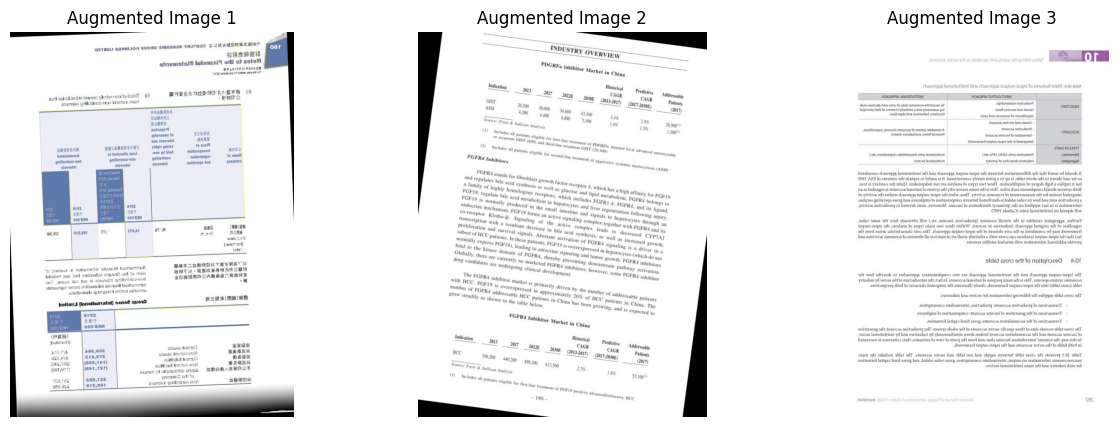

In [49]:
import os
import cv2
import matplotlib.pyplot as plt
import random

# Пути к аугментированным изображениям
aug_images_path = "table_dataset/images/train_aug"

# Получаем список всех аугментированных изображений
aug_images = [img for img in os.listdir(aug_images_path) if img.endswith(".jpg")]

# Случайным образом выбираем 3 изображения
random_images = random.sample(aug_images, 3)

# Создаем фигуру для отображения
plt.figure(figsize=(15, 5))

# Загружаем и отображаем каждое изображение
for i, img_file in enumerate(random_images):
    img_path = os.path.join(aug_images_path, img_file)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Augmented Image {i+1}")

plt.show()

# Обучение модели на аугментированных данных

In [3]:
import torch

torch.cuda.is_available()


False

In [1]:
! nvidia-smi

Sat Mar  1 16:14:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.42                 Driver Version: 572.42         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   40C    P0             99W /  320W |    1571MiB /  10240MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
! pip uninstall torch torchvision torchaudio --yes

Found existing installation: torch 2.6.0
Uninstalling torch-2.6.0:
  Successfully uninstalled torch-2.6.0
Found existing installation: torchvision 0.21.0
Uninstalling torchvision-0.21.0:
  Successfully uninstalled torchvision-0.21.0
Found existing installation: torchaudio 2.6.0
Uninstalling torchaudio-2.6.0:
  Successfully uninstalled torchaudio-2.6.0


In [2]:
! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126
  Obtaining dependency information for torch from https://download.pytorch.org/whl/cu126/torch-2.6.0%2Bcu126-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torchvision from https://download.pytorch.org/whl/cu126/torchvision-0.21.0%2Bcu126-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torchaudio from https://download.pytorch.org/whl/cu126/torchaudio-2.6.0%2Bcu126-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/2.5 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 GB 1.6 MB/s eta 0:26:01
   ---------------------------------------- 0.0/2.5 GB 2.6 MB/s eta 0:15:51
   ---------------------------------------- 0.0/2.5 GB 4.3 MB/s eta 0:09:46
   ---------------------------------------- 0.0/2.5 GB 6.7 MB/s eta 0:06:11
   ---------------------------------------- 0.0/2.5 GB 9.8 MB/s eta 0:04:15
   ----------------------------------


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch

torch.cuda.is_available()

True

In [15]:
from ultralytics import YOLO

# Загружаем предобученные веса (например, yolo8s.pt)
model = YOLO('yolov8s.pt')

# Запускаем обучение
model.train(
    data='table_data.yaml',  # data.yaml
    epochs=50,               # кол-во эпох 
    imgsz=640,               # размер входного изображения 
    batch=16,                # размер batch
    name='table_detection',  # подпапка для логов (runs/detect/table_detection/)
    device=0
)

New https://pypi.org/project/ultralytics/8.3.81 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.72  Python-3.11.7 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=table_data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=table_detection9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sav

train: Scanning F:\GitHub\datasets\table_dataset\labels\train... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<00:00, 1607.64it/s]

train: New cache created: F:\GitHub\datasets\table_dataset\labels\train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning F:\GitHub\datasets\table_dataset\labels\val... 140 images, 0 backgrounds, 0 corrupt: 100%|██████████| 140/140 [00:00<00:00, 812.12it/s]


val: New cache created: F:\GitHub\datasets\table_dataset\labels\val.cache
Plotting labels to f:\GitHub\table-parser\runs\detect\table_detection9\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to f:\GitHub\table-parser\runs\detect\table_detection9
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.29G      1.186      2.809      1.366         43        640: 100%|██████████| 30/30 [00:04<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.39it/s]

                   all        140        218      0.701      0.553      0.595      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       3.9G     0.8927      1.406       1.16         39        640: 100%|██████████| 30/30 [00:03<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.21it/s]

                   all        140        218      0.278      0.293      0.199      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.85G     0.9794       1.29      1.197         40        640: 100%|██████████| 30/30 [00:03<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.76it/s]

                   all        140        218     0.0244      0.342     0.0215    0.00601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       3.9G     0.9589      1.197      1.201         38        640: 100%|██████████| 30/30 [00:03<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.78it/s]

                   all        140        218      0.458      0.411       0.35      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.82G     0.9328      1.103      1.157         39        640: 100%|██████████| 30/30 [00:03<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.96it/s]

                   all        140        218      0.781      0.415      0.503      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.87G      0.852      1.021      1.139         49        640: 100%|██████████| 30/30 [00:03<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.39it/s]

                   all        140        218      0.497       0.49      0.425      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         4G     0.8494     0.9781      1.106         43        640: 100%|██████████| 30/30 [00:03<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.90it/s]

                   all        140        218      0.712      0.671      0.725      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.84G     0.7693      0.931      1.081         47        640: 100%|██████████| 30/30 [00:03<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.77it/s]

                   all        140        218      0.552      0.414      0.431      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.84G     0.7535     0.9288      1.086         43        640: 100%|██████████| 30/30 [00:03<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.14it/s]

                   all        140        218       0.84      0.669      0.723       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.87G     0.7453     0.8516      1.066         54        640: 100%|██████████| 30/30 [00:03<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.93it/s]

                   all        140        218      0.865      0.854      0.889      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.84G      0.709     0.7914      1.051         42        640: 100%|██████████| 30/30 [00:03<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.33it/s]

                   all        140        218      0.858      0.794      0.851      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.87G     0.7093     0.8039      1.049         56        640: 100%|██████████| 30/30 [00:03<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.46it/s]

                   all        140        218      0.779       0.59      0.688      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.84G      0.674     0.7782      1.036         43        640: 100%|██████████| 30/30 [00:03<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.18it/s]

                   all        140        218      0.682      0.809      0.784      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.89G     0.6827     0.7468      1.025         30        640: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.58it/s]

                   all        140        218      0.874      0.792      0.847      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.03G      0.687     0.7504      1.045         39        640: 100%|██████████| 30/30 [00:03<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.54it/s]

                   all        140        218      0.639      0.484      0.515      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.85G     0.6535     0.7403      1.039         45        640: 100%|██████████| 30/30 [00:03<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.70it/s]

                   all        140        218      0.765      0.701      0.776      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         4G     0.6129     0.6895      1.026         42        640: 100%|██████████| 30/30 [00:03<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.44it/s]

                   all        140        218      0.859      0.797      0.843      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.86G     0.5775     0.6339     0.9881         47        640: 100%|██████████| 30/30 [00:03<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.33it/s]

                   all        140        218      0.834      0.829      0.884      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.98G      0.575     0.6102     0.9955         56        640: 100%|██████████| 30/30 [00:03<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.10it/s]

                   all        140        218      0.848      0.821      0.887      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.87G     0.6216     0.6589      1.006         48        640: 100%|██████████| 30/30 [00:03<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.53it/s]


                   all        140        218      0.866      0.742      0.846       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.82G     0.5869     0.6467     0.9881         48        640: 100%|██████████| 30/30 [00:03<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.06it/s]

                   all        140        218      0.712      0.726      0.749      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.87G      0.566     0.6142     0.9844         36        640: 100%|██████████| 30/30 [00:03<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.07it/s]

                   all        140        218      0.838      0.739      0.807      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.84G     0.5404     0.6071     0.9758         43        640: 100%|██████████| 30/30 [00:03<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.06it/s]

                   all        140        218      0.759       0.75      0.802      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.84G     0.5422     0.5631     0.9744         39        640: 100%|██████████| 30/30 [00:03<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.33it/s]

                   all        140        218       0.77      0.785      0.785      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         4G     0.5383     0.5678     0.9611         40        640: 100%|██████████| 30/30 [00:03<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.77it/s]

                   all        140        218      0.803      0.752        0.8      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.86G     0.5434     0.5656     0.9729         41        640: 100%|██████████| 30/30 [00:03<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.63it/s]

                   all        140        218      0.884      0.803      0.903      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.96G     0.5348     0.5592     0.9647         47        640: 100%|██████████| 30/30 [00:03<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.89it/s]

                   all        140        218      0.884      0.793      0.872      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.84G     0.5337     0.5227     0.9639         35        640: 100%|██████████| 30/30 [00:03<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.96it/s]

                   all        140        218      0.881      0.785      0.889      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.84G     0.5026     0.5255     0.9486         31        640: 100%|██████████| 30/30 [00:03<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.21it/s]

                   all        140        218      0.769      0.655      0.708      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.85G     0.4813     0.4894     0.9512         42        640: 100%|██████████| 30/30 [00:03<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.30it/s]

                   all        140        218      0.876      0.794      0.878      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.82G     0.4682     0.4903     0.9416         33        640: 100%|██████████| 30/30 [00:03<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.34it/s]

                   all        140        218      0.879      0.819      0.903      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.87G     0.4626     0.4915     0.9334         50        640: 100%|██████████| 30/30 [00:03<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.38it/s]

                   all        140        218      0.883      0.843      0.917      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.84G     0.4473     0.4626     0.9308         47        640: 100%|██████████| 30/30 [00:03<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.44it/s]

                   all        140        218      0.914      0.814      0.868      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.86G     0.4563      0.455     0.9486         39        640: 100%|██████████| 30/30 [00:03<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.76it/s]

                   all        140        218      0.896      0.923      0.949      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.03G     0.4567      0.473     0.9363         38        640: 100%|██████████| 30/30 [00:03<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.58it/s]

                   all        140        218        0.9      0.753      0.869      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.86G     0.4482     0.4596     0.9363         38        640: 100%|██████████| 30/30 [00:03<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.37it/s]

                   all        140        218      0.898      0.922      0.938      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.98G     0.4277     0.4437     0.9361         42        640: 100%|██████████| 30/30 [00:03<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.08it/s]

                   all        140        218      0.932      0.837       0.91      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.87G     0.4148      0.425     0.9138         49        640: 100%|██████████| 30/30 [00:03<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.41it/s]


                   all        140        218      0.918      0.844      0.911      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         4G     0.4088     0.4085     0.9139         39        640: 100%|██████████| 30/30 [00:03<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.48it/s]

                   all        140        218      0.884      0.852      0.904      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.85G     0.4227      0.427     0.9293         38        640: 100%|██████████| 30/30 [00:03<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.48it/s]

                   all        140        218      0.919      0.852      0.907      0.809


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.82G     0.3663     0.3688     0.8815         21        640: 100%|██████████| 30/30 [00:03<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.46it/s]

                   all        140        218      0.849      0.883      0.934      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.85G     0.3425     0.3376      0.873         19        640: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.28it/s]

                   all        140        218      0.811      0.622      0.725      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.98G     0.3328     0.3105     0.8694         21        640: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.37it/s]

                   all        140        218      0.907      0.835      0.891      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.85G     0.3294     0.3332     0.8412         28        640: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.57it/s]

                   all        140        218      0.883      0.912      0.942      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.82G     0.3134     0.3005     0.8502         16        640: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.51it/s]

                   all        140        218      0.918      0.825      0.932      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.85G     0.3319      0.343     0.8726         21        640: 100%|██████████| 30/30 [00:03<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.62it/s]

                   all        140        218      0.929      0.826       0.94      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.82G     0.3054     0.2978     0.8504         18        640: 100%|██████████| 30/30 [00:03<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.42it/s]

                   all        140        218      0.936       0.88      0.948      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.85G     0.2844     0.2656     0.8399         22        640: 100%|██████████| 30/30 [00:03<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.27it/s]

                   all        140        218      0.934      0.854      0.939      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.98G     0.3195      0.322     0.8701         20        640: 100%|██████████| 30/30 [00:03<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.40it/s]

                   all        140        218      0.881      0.897      0.937      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.85G      0.293     0.2834     0.8439         14        640: 100%|██████████| 30/30 [00:03<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.92it/s]

                   all        140        218      0.946      0.843      0.938       0.86



50 epochs completed in 0.087 hours.
Optimizer stripped from f:\GitHub\table-parser\runs\detect\table_detection9\weights\last.pt, 22.5MB
Optimizer stripped from f:\GitHub\table-parser\runs\detect\table_detection9\weights\best.pt, 22.5MB

Validating f:\GitHub\table-parser\runs\detect\table_detection9\weights\best.pt...
Ultralytics 8.3.72  Python-3.11.7 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]


                   all        140        218      0.937       0.88      0.948      0.861
              bordered         36         46      0.973      0.848      0.965        0.9
            borderless        104        172      0.901      0.913      0.931      0.822
Speed: 0.5ms preprocess, 2.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to f:\GitHub\table-parser\runs\detect\table_detection9


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000299FFA4E750>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

In [27]:
model = YOLO("../runs/detect/table_detection9/weights/best.pt")

In [28]:
# Запустим инференс на одном изображении
results = model.predict(
    source="../resources/images/5.jpg", 
    conf=0.25,  # порог confidence
    save=True
)


image 1/1 f:\GitHub\table-parser\yolo\..\resources\images\5.jpg: 320x640 1 borderless, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Results saved to f:\GitHub\table-parser\runs\detect\predict4


In [30]:
import matplotlib.pyplot as plt
import cv2

# Путь к изображению
image_path = "../runs/detect/predict4/5.jpg"

# Загружаем изображение с помощью OpenCV
image = cv2.imread(image_path)

# Конвертируем BGR в RGB (OpenCV загружает в BGR, а matplotlib ожидает RGB)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Отображаем изображение
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis("off")  # Отключаем оси для чистоты
plt.title("Отображение изображения")
plt.show()


<Figure size 1000x800 with 1 Axes>